Time to generate Sx: 0.0004992485046386719 sec
Time to generate Js: 0.1746048927307129 sec
time for sim =  0.6089861392974854 s


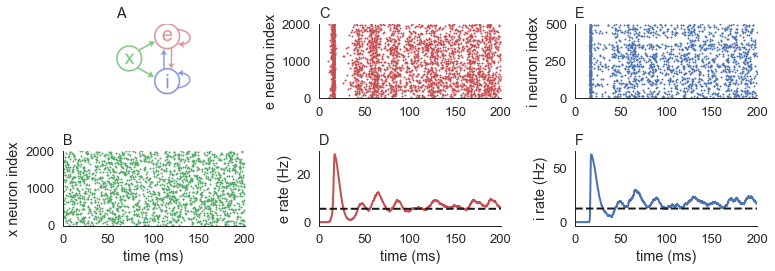

In [6]:
###############################################
## Import packages and specify some settings ##
###############################################
# Import packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# This makes plots show up and look nice
%matplotlib inline
sns.set(context='paper',style='white',font_scale=1.5,rc={"lines.linewidth":2.5})
sns.set_palette('muted')

# Keep this set to false unless you want to save figures and data
# (in which case you'll need to change some directories below)
SaveFigures=False
###############################################
###############################################

# For computing runtimes
from time import time as tm

# Seed random number generator so that
# we get the same results every time
# we run this code
np.random.seed(6)

# Discretized time
T=200
dt=.1
time=np.arange(0,T,dt)
Nt=len(time)

# Number of external, exc and inh neurons
Nx=2000
Ne=2000 
Ni=500 

# Connection strengths
jex=25
jix=17
jee=10
jei=-40
jie=30
jii=-60

# Connection probabilities
pex=.1
pix=.1
pee=.1 
pei=.1 
pie=.1 
pii=.1

# External neuron firing rates
rx=5/1000

# EIF neuron parameters
taum=10 
EL=-72 
Vre=-72 
VT=-55 
D=2 
Vth=0

# Synaptic time constants
taux=8
taue=6
taui=4 

# EIF nonlinearity. Defining this function
# makes the Euler code below more concise
# psi=@(V)(DeltaT*exp((V-VT)/DeltaT)) 

# Generate external spike trains as Poisson processes
t0=tm()
nsx=np.random.poisson(rx*T*Nx) # Number of spikes
SxTimes=np.sort(np.random.rand(nsx)*T) # Random spike times
SxIndices=np.random.randint(Nx,size=nsx) # Random neuron Indices
print('Time to generate Sx:',tm()-t0,'sec')


# Initialize membrane potentials randomly
Ve=np.random.rand(Ne)*(VT-EL)+EL
Vi=np.random.rand(Ni)*(VT-EL)+EL


# Initialize all else as zeros
Iex=np.zeros(Ne)#+np.random.rand(Ne)*25
Iee=np.zeros(Ne)
Iei=np.zeros(Ne)
Iix=np.zeros(Ni)#+np.random.rand(Ni)*17
Iie=np.zeros(Ni)
Iii=np.zeros(Ni)

# Allocate arrays for maximum number of e and i spikes
eMaxNumSpikes=int(Ne*T*50/1000)
iMaxNumSpikes=int(Ni*T*50/1000)
SeTimes=np.zeros(eMaxNumSpikes)
SeIndices=np.zeros(eMaxNumSpikes)
SiTimes=np.zeros(iMaxNumSpikes)
SiIndices=np.zeros(iMaxNumSpikes)


# Connection matrices
t0=tm()
Jex=jex*np.random.binomial(1,pex,(Ne,Nx))
Jee=jee*np.random.binomial(1,pee,(Ne,Ne))
Jei=jei*np.random.binomial(1,pei,(Ne,Ni))
Jix=jix*np.random.binomial(1,pix,(Ni,Nx))
Jie=jie*np.random.binomial(1,pie,(Ni,Ne))
Jii=jii*np.random.binomial(1,pii,(Ni,Ni))
print('Time to generate Js:',tm()-t0,'sec')

t0=tm()
eNumSpikes=0
iNumSpikes=0
iX=0
for i in range(len(time)-1):

    # Euler step for membrane potentials
    Ve=Ve+dt*(-(Ve-EL)+D*np.exp((Ve-VT)/D)+Iex+Iee+Iei)/taum 
    Vi=Vi+dt*(-(Vi-EL)+D*np.exp((Vi-VT)/D)+Iix+Iie+Iii)/taum 

    # Euler step for synaptic currents
    Iex=Iex+dt*(-Iex)/taux      
    Iee=Iee+dt*(-Iee)/taue
    Iei=Iei+dt*(-Iei)/taui    
    Iix=Iix+dt*(-Iix)/taux    
    Iie=Iie+dt*(-Iie)/taue
    Iii=Iii+dt*(-Iii)/taui
    
    # Update synaptic currents from external pop.
    while iX<len(SxTimes) and SxTimes[iX]<i*dt:
        Iex=Iex+Jex[:,SxIndices[iX]]/taux
        Iix=Iix+Jix[:,SxIndices[iX]]/taux
        iX+=1
        
    # Find which excitatory neurons spiked.
    Inds=np.nonzero(Ve>=Vth)[0]
    # Reset membrane potentials
    Ve[Inds]=Vre
    # Store spikes
    if eNumSpikes<eMaxNumSpikes and len(Inds)>0:
        SeTimes[eNumSpikes:eNumSpikes+len(Inds)]=i*dt
        SeIndices[eNumSpikes:eNumSpikes+len(Inds)]=Inds
    # Increment synaptic currents
    Iee=Iee+np.sum(Jee[:,Inds],axis=1)/taue
    Iie=Iie+np.sum(Jie[:,Inds],axis=1)/taue
    # Update spike counts
    eNumSpikes+=len(Inds)
        
    # Now do the same for inhibitory neurons
    Inds=np.nonzero(Vi>=Vth)[0] 
    Vi[Inds]=Vre
    if iNumSpikes<iMaxNumSpikes and len(Inds)>0:
        SiTimes[iNumSpikes:iNumSpikes+len(Inds)]=i*dt
        SiIndices[iNumSpikes:iNumSpikes+len(Inds)]=Inds
    Iei=Iei+np.sum(Jei[:,Inds],axis=1)/taui
    Iii=Iii+np.sum(Jii[:,Inds],axis=1)/taui
    iNumSpikes+=len(Inds)    

SeTimes=SeTimes[:eNumSpikes]
SeIndices=SeIndices[:eNumSpikes]
SiTimes=SiTimes[:iNumSpikes]
SiIndices=SiIndices[:iNumSpikes]
print('time for sim = ',tm()-t0,'s')

#reBar=eNumSpikes/(T*Ne))
#riBar=print(iNumSpikes/(T*Ni))

# Mean-field connectivity
wex=jex*pex*Nx 
wix=jix*pix*Nx 
wee=jee*pee*Ne 
wei=jei*pei*Ni 
wie=jie*pie*Ne
wii=jii*pii*Ni 
Wx=np.array([[wex],[wix]])
W=np.array([[wee, wei],  [wie, wii]])

# Mean-field external input
X=Wx*rx

# Mean-field rate
# f-I curve fit from other file
data = np.load('./EIFfIcurve.npz',allow_pickle=True)
g=data['gfit']
theta=data['thetafit']
rBarMF=np.linalg.inv((1/g)*np.eye(2)-W)@(X-theta)
print(1000*rBarMF)

# Compute a smoothed neuron-averaged rate
sigma=6
s=np.arange(-3*sigma,3*sigma,dt)
k=np.exp(-(s**2)/(2*sigma**2))
# Make it a causal filter
k[s<0]=0 
k=k/(sum(k)*dt)
re=np.histogram(SeTimes,time)[0]/(dt*Ne)
re=np.convolve(k,re,'same')*dt
ri=np.histogram(SiTimes,time)[0]/(dt*Ni)
ri=np.convolve(k,ri,'same')*dt


# Make figure
plt.subplots(figsize=(11, 4))

plt.subplot(2,3,1)
im = plt.imread('EIRecurrentNet.png')
plt.imshow(im,interpolation='hanning')
plt.axis('off')
plt.title('A',loc='left')

plt.subplot(2,3,4)
plt.plot(SxTimes,SxIndices,'g.',markersize=2)
plt.xlabel('time (ms)')
plt.xlim([0,T])
plt.ylim([0,Nx])
plt.ylabel('x neuron index')
plt.title('B',loc='left')
sns.despine()

plt.subplot(2,3,2)
plt.plot(SeTimes,SeIndices,'r.',markersize=2)
plt.xlim([0,T])
plt.ylim([0,Ne])
#plt.xlabel('time (ms)')
plt.ylabel('e neuron index')
plt.title('C',loc='left')
sns.despine()

plt.subplot(2,3,5)
plt.plot(time[:-1],1000*re,'r')
plt.plot(time,1000*rBarMF[0]+np.zeros_like(time),'k--')
plt.xlim([0,T])
plt.xlabel('time (ms)')
plt.ylabel('e rate (Hz)')
plt.title('D',loc='left')
sns.despine()

plt.subplot(2,3,3)
plt.plot(SiTimes,SiIndices,'b.',markersize=2)
plt.xlim([0,T])
plt.ylim([0,Ni])
#plt.xlabel('time (ms)')
plt.ylabel('i neuron index')
plt.title('E',loc='left')
sns.despine()

plt.subplot(2,3,6)
plt.plot(time[:-1],1000*ri,'b')
plt.xlim([0,T])
plt.plot(time,1000*rBarMF[1]+np.zeros_like(time),'k--')
plt.xlabel('time (ms)')
plt.ylabel('i rate (Hz)')
plt.title('F',loc='left')
sns.despine()


plt.tight_layout()

# Save figure if needed
if SaveFigures:
      plt.savefig('../Figures/RecurrentSpikingNet.pdf')

